In [1]:
import os
import nltk
import time
import datetime
import numpy as np
import scipy as sp
import pandas as pd

from itertools import product
from nltk.corpus import stopwords
from scipy.sparse import hstack

from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, roc_curve, mean_squared_error, make_scorer, confusion_matrix
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, StratifiedKFold, validation_curve, StratifiedShuffleSplit
from sklearn.feature_extraction import text

from utility.processing import *
from utility.utility import *

from imblearn.combine import *
from imblearn.over_sampling import *
from imblearn.under_sampling import * 
from imblearn.pipeline import Pipeline, make_pipeline

from joblib import Parallel, delayed
%matplotlib inline

# Crowdflower Search Results Relevance

## 데이터 로드

In [2]:
train = pd.read_csv('./data/preprocessed_train.csv')
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)
y = train.median_relevance.values

In [3]:
train, dev, y, y_dev = train_test_split(train, y, stratify=y, test_size=0.1)

In [4]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

dev_query = list(dev.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
dev_title = list(dev.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

## 모델링

### TF-IDF

In [5]:
# min_df=3 : 빈도수가 3번 이하인 단어 무시
# max_features=None : 단어 빈도수의 맥시멈 설정 x
# strip_accents='unicode' : 모든 특수문자와 pattern을 정재할수 없으므로 unicode사용
# analyzer='word' : corpus가 문장 list로 이루어져있어 단어단위로 분석
# token_pattern=r'\w{1,}' : analyzer == 'word'일 때 token_pattern을 기반으로 단어 인식
# ngram_range=(1, 3) : word window의 범위 1~3, 약 90% 쿼리가 word size 3이하로 이루어짐
# use_idf=True : idf사용
# smooth_idf=True : 분모가 0이 되는것을 방지
# sublinear_tf=True : 단어 스무딩, replace 1 + log(tf).
# stop_words : 불용어 제거
stop_words = text.ENGLISH_STOP_WORDS.union(['http', 'www', 'img', 'border', 'color', 'style', 'padding', 'table', 'font', '',
                                            'thi', 'inch', 'ha', 'width', 'height', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))

tfv = text.TfidfVectorizer(min_df=7, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                           ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                           stop_words=stop_words).fit(train_query + train_title)

X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
X_dev = hstack([tfv.transform(dev_query), tfv.transform(dev_title)])
X_test = hstack([tfv.transform(test_query), tfv.transform(test_title)])

In [6]:
# 단어별 가중치 확인
# idf_dict = dict(zip(tfv.get_feature_names(), tfv.idf_))

### cos, jaccard similarlity stack

In [7]:
# query, title 유사도 계산(cos, jaccard)
sim = similarlity_stack()
X_sim_train = sim.fit_transform(X_train, y)
X_sim_dev = sim.transform(X_dev)
X_sim_test = sim.transform(X_test)

In [8]:
for i in range(1, 5):
    sims = X_sim_train.toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \ncos_sim mean : %f\t jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

ratings 1 
cos_sim mean : 0.159919	 jaccard_sim mean: 0.106141

ratings 2 
cos_sim mean : 0.274563	 jaccard_sim mean: 0.188866

ratings 3 
cos_sim mean : 0.347661	 jaccard_sim mean: 0.242597

ratings 4 
cos_sim mean : 0.435886	 jaccard_sim mean: 0.311592



#### LogisticRegression

In [9]:
lr = LogisticRegression(max_iter=500)

X_train_sim = hstack([X_train, X_sim_train])
X_dev_sim = hstack([X_dev, X_sim_dev])

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(lr, X_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("lr without sim kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

kappa_scores = cross_val_score(lr, X_train_sim, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("lr with sim kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

lr without sim kappa score 평균 : 0.50, 편차 : 0.02
lr with sim kappa score 평균 : 0.58, 편차 : 0.02


### LSA

In [10]:
# TruncatedSVD
# 261개의 쿼리이므로 n_components = 250로 모델링 시작
svd = TruncatedSVD(n_components = 250)
X_svd_train = svd.fit_transform(X_train)
X_svd_dev = svd.transform(X_dev)
X_svd_test = svd.transform(X_test)

In [11]:
# Truncated SVD와 유사도 hstack
X_stacked_train = hstack([X_svd_train, X_sim_train])
X_stacked_dev = hstack([X_svd_dev, X_sim_dev])
X_stacked_test = hstack([X_svd_test, X_sim_test])

In [12]:
# StandardScaler
# with_mean=False 행렬이 희소하고 [0,1]이므로 mean shift사용 X
scl = StandardScaler(with_mean=False)
X_scaled_train = scl.fit_transform(X_stacked_train)
X_scaled_dev = scl.transform(X_stacked_dev)
X_scaled_test = scl.transform(X_stacked_test)

In [13]:
for i in range(1, 5):
    sims = X_scaled_train[:,-2:].toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \nscaled cos_sim mean : %f\t scaled jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

ratings 1 
scaled cos_sim mean : 0.671321	 scaled jaccard_sim mean: 0.523417

ratings 2 
scaled cos_sim mean : 1.114229	 scaled jaccard_sim mean: 0.894946

ratings 3 
scaled cos_sim mean : 1.386019	 scaled jaccard_sim mean: 1.123286

ratings 4 
scaled cos_sim mean : 1.756968	 scaled jaccard_sim mean: 1.444174



### classification(LogisticRegression)

In [14]:
lr = LogisticRegression(max_iter=500)

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(lr, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)

print("scaled lr kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

scaled lr without sim kappa score 평균 : 0.36, 편차 : 0.02
scaled lr with sim kappa score 평균 : 0.50, 편차 : 0.02


### classification(SVM)

In [15]:
# C=100(패널티) 문서당 유사도가 크기때문에(쿼리의 중복) 100으로 잡고 시작
svm = SVC(C = 100, gamma='auto', probability=True)

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(svm, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("svm kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

svm without sim kappa score 평균 : 0.62, 편차 : 0.01
svm with sim kappa score 평균 : 0.62, 편차 : 0.01


## 모델링 결과 해석

kappa
train : 0.901398	dev : 0.614689
rmse
train : 0.434132	dev : 0.848226

confusion_matrix : 1016개중 346개를 틀림
 [[ 35  29   3  10]
 [ 10  68  28  42]
 [ 10  28  43  93]
 [  4  36  53 524]]

classification_report :
               precision    recall  f1-score   support

           1       0.59      0.45      0.51        77
           2       0.42      0.46      0.44       148
           3       0.34      0.25      0.29       174
           4       0.78      0.85      0.81       617

    accuracy                           0.66      1016
   macro avg       0.53      0.50      0.51      1016
weighted avg       0.64      0.66      0.65      1016



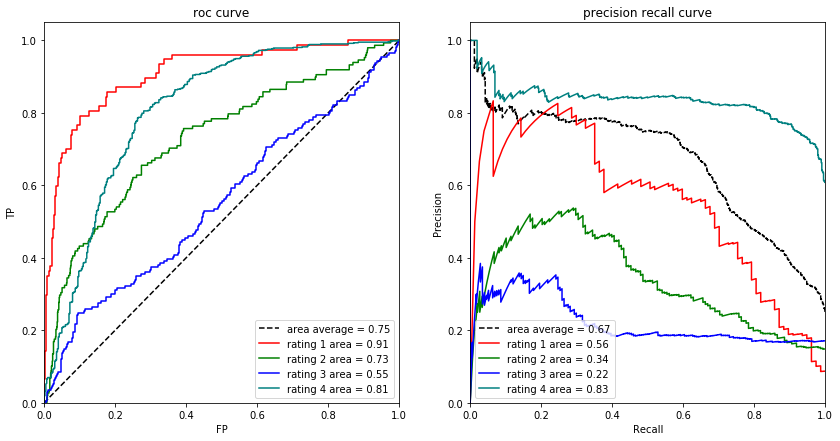

In [16]:
svm_result = svm.fit(X_scaled_train, y)
svm_pred_train = svm_result.predict(X_scaled_train)
svm_pred_dev = svm_result.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y, svm_pred_train), \
                                      metric.quadratic_weighted_kappa(y_dev, svm_pred_dev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y, svm_pred_train)**0.5, \
                                     mean_squared_error(y_dev, svm_pred_dev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svm_pred_dev!=y_dev)[0])), \
      confusion_matrix(y_dev, svm_pred_dev))
print('\nclassification_report :\n', classification_report(y_dev, svm_pred_dev))

plot_multiclass_roc_prc(svm, X_scaled_dev, y_dev)

## 개선된 모델

### Over sampling(SVMSMOTE)

sampling finish
fitting finish
kappa
train : 0.929231	dev : 0.651356
rmse
train : 0.422783	dev : 0.816898

confusion_matrix : 1016개중 345개를 틀림
 [[ 49  20   3   5]
 [ 13  68  31  36]
 [  6  29  59  80]
 [  7  34  81 495]]

classification_report :
               precision    recall  f1-score   support

           1       0.65      0.64      0.64        77
           2       0.45      0.46      0.45       148
           3       0.34      0.34      0.34       174
           4       0.80      0.80      0.80       617

    accuracy                           0.66      1016
   macro avg       0.56      0.56      0.56      1016
weighted avg       0.66      0.66      0.66      1016



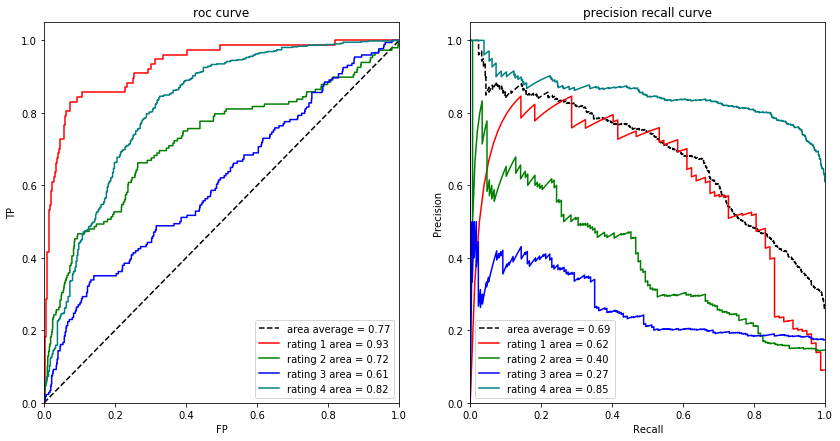

In [17]:
svmsmote = SVMSMOTE(sampling_strategy='not majority', k_neighbors=4, svm_estimator=SVC(C=10), n_jobs=-1)
X_samp, y_samp = svmsmote.fit_sample(X_scaled_train, y)
print('sampling finish')
svm = SVC(C=10, probability=True)
svmresult = svm.fit(X_samp, y_samp)
print('fitting finish')
svmpredtrain = svmresult.predict(X_samp)
svmpreddev = svmresult.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_samp, svmpredtrain), \
                                      metric.quadratic_weighted_kappa(y_dev, svmpreddev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_samp, svmpredtrain)**0.5, \
                                     mean_squared_error(y_dev, svmpreddev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svmpreddev!=y_dev)[0])), \
      confusion_matrix(y_dev, svmpreddev))
print('\nclassification_report :\n', classification_report(y_dev, svmpreddev))

plot_multiclass_roc_prc(svmresult, X_scaled_dev, y_dev)

#### search k_neighbors for SVMSMOTE

In [18]:
from sklearn.base import clone

def _svm_smote(svm, smt, X, Y, train_index, test_index):
    print('sampling start')
    X_samp, y_samp = smt.fit_sample(X[train_index], Y[train_index])
    svm_result = svm.fit(X_samp, y_samp)
    svm_pred_dev = svm_result.predict(X[test_index])
    svm_pred_proba_dev = svm_result.predict_proba(X[test_index])
    print('end')
    return metric.quadratic_weighted_kappa(Y[test_index], svm_pred_dev), metric.pr_auc_score(Y[test_index], svm_pred_proba_dev)

In [19]:
_k_fold = StratifiedKFold(n_splits=4, shuffle=True)
parallel = Parallel(n_jobs=2)

svm = SVC(C=10, gamma='auto', psobability=True)
scores_list = []
for k in range(1, 11):
    smt = SVMSMOTE(sampling_strategy='not majority', svm_estimator=SVC(C=100, gamma='auto'), n_jobs=2, k_neighbors=k)
    scores = parallel(
        delayed(_svm_smote)(clone(svm), clone(smt), X_scaled_train, y, train_index, test_index) 
        for train_index, test_index in _k_fold.split(X_scaled_train, y)
    )
    scores_list.append(scores)

In [20]:
kappa_test_scores_mean, kappa_test_scores_std, auc_test_scores_mean,auc_test_scores_std = [], [], [], []
for score_static in scores_list:
    kappa_test_scores_mean.append(np.mean(score_static, axis=0)[0])
    kappa_test_scores_std.append(np.std(score_static, axis=0)[0])
    auc_test_scores_mean.append(np.mean(score_static, axis=0)[1])
    auc_test_scores_std.append(np.std(score_static, axis=0)[1])
kappa_test_scores_mean = np.array(kappa_test_scores_mean)
kappa_test_scores_std = np.array(kappa_test_scores_std)
auc_test_scores_mean = np.array(auc_test_scores_mean)
auc_test_scores_std = np.array(auc_test_scores_std)

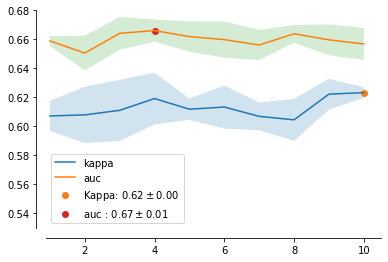

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

param_range = range(1, 11)
plt.plot(param_range, kappa_test_scores_mean, label='kappa')
ax.fill_between(param_range, kappa_test_scores_mean + kappa_test_scores_std,
                kappa_test_scores_mean - kappa_test_scores_std, alpha=0.2)
kappa_idx_max = np.argmax(kappa_test_scores_mean)
plt.scatter(param_range[kappa_idx_max], kappa_test_scores_mean[kappa_idx_max],
            label=r'Kappa: ${:.2f}\pm{:.2f}$'.format(kappa_test_scores_mean[kappa_idx_max], kappa_test_scores_std[kappa_idx_max]))


plt.plot(param_range, auc_test_scores_mean, label='auc')
ax.fill_between(param_range, auc_test_scores_mean + auc_test_scores_std,
                auc_test_scores_mean - auc_test_scores_std, alpha=0.2)
auc_idx_max = np.argmax(auc_test_scores_mean)
plt.scatter(param_range[auc_idx_max], auc_test_scores_mean[auc_idx_max],
            label=r'auc : ${:.2f}\pm{:.2f}$'.format(auc_test_scores_mean[auc_idx_max], auc_test_scores_std[auc_idx_max]))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0.9, 10.5])
plt.ylim([0.53, 0.68])

plt.legend(loc="best")
plt.show()

### Data augmentation

In [22]:
df_train = pd.read_csv('./data/preprocessed_eda_train.csv')
df_train.drop_duplicates(keep='first', inplace=True)
df_train.set_index('id', inplace=True)
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)
test.set_index('id', inplace=True)

for i in range(1, 5):
    print('number of median_relevance %d: '%i, len(df_train.groupby('median_relevance').get_group(i)))

Y = df_train['median_relevance']
df_train = df_train[['query_preprocessed', 'product_title_preprocessed']]
test = test[['query_preprocessed', 'product_title_preprocessed']]

number of median_relevance 1:  5495
number of median_relevance 2:  6154
number of median_relevance 3:  7262
number of median_relevance 4:  10765


In [23]:
_k_fold = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
train_index, test_index = next(_k_fold.split(df_train.index.unique(), Y.loc[~Y.index.duplicated(keep='first')]))

In [24]:
train_idx = df_train.index.unique()[train_index]
dev_idx = df_train.index.unique()[test_index]

train, dev = df_train.loc[train_idx], df_train.loc[dev_idx]
y, y_dev = Y.loc[train_idx], Y.loc[dev_idx]

dev = dev.loc[~dev.index.duplicated(keep='first')]
y_dev = y_dev.loc[~y_dev.index.duplicated(keep='first')]

rand_idx = np.random.permutation(np.arange(train.shape[0]))
train = train.iloc[rand_idx]
y = y.iloc[rand_idx]

In [25]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

dev_query = list(dev.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
dev_title = list(dev.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

In [26]:
stop_words = text.ENGLISH_STOP_WORDS.union(['http', 'www', 'img', 'border', 'color', 'style', 'padding', 'table', 'font', '',
                                            'thi', 'inch', 'ha', 'width', 'height', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))

tfv = text.TfidfVectorizer(min_df=10, max_df=0.9, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                           ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                           stop_words=stop_words).fit(train_query + train_title)

X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
X_dev = hstack([tfv.transform(dev_query), tfv.transform(dev_title)])
X_test = hstack([tfv.transform(test_query), tfv.transform(test_title)])

In [27]:
print(X_train.shape, '\n')
sim = similarlity_stack()
X_sim_train = sim.fit_transform(X_train, y)
X_sim_dev = sim.transform(X_dev)
X_sim_test = sim.transform(X_test)

for i in range(1, 5):
    sims = X_sim_train[:,-2:].toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \n cos_sim mean : %f\t jaccard_sim mean : %f\n" % (i, sims[0], sims[1]))

(26691, 14230) 

ratings 1 
scaled cos_sim mean : 0.071625	 scaled jaccard_sim mean : 0.049156

ratings 2 
scaled cos_sim mean : 0.210277	 scaled jaccard_sim mean : 0.146121

ratings 3 
scaled cos_sim mean : 0.274546	 scaled jaccard_sim mean : 0.190484

ratings 4 
scaled cos_sim mean : 0.387785	 scaled jaccard_sim mean : 0.276595



In [28]:
svd = TruncatedSVD(n_components = 100)
X_svd_train = svd.fit_transform(X_train)
X_svd_dev = svd.transform(X_dev)
X_svd_test = svd.transform(X_test)

X_stacked_train = hstack([X_svd_train, X_sim_train])
X_stacked_dev = hstack([X_svd_dev, X_sim_dev])
X_stacked_test = hstack([X_svd_test, X_sim_test])

scl = StandardScaler(with_mean=False)
X_scaled_train = scl.fit_transform(X_stacked_train)
X_scaled_dev = scl.transform(X_stacked_dev)
X_scaled_test = scl.transform(X_stacked_test)

for i in range(1, 5):
    sims = X_scaled_train[:,-2:].toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \nscaled cos_sim mean : %f\t scaled jaccard_sim mean : %f\n" % (i, sims[0], sims[1]))

ratings 1 
scaled cos_sim mean : 0.326654	 scaled jaccard_sim mean : 0.280449	 scaled text_sim mean: 0.409946

ratings 2 
scaled cos_sim mean : 0.969470	 scaled jaccard_sim mean : 0.843701	 scaled text_sim mean: 1.155706

ratings 3 
scaled cos_sim mean : 1.261739	 scaled jaccard_sim mean : 1.099109	 scaled text_sim mean: 1.446495

ratings 4 
scaled cos_sim mean : 1.767697	 scaled jaccard_sim mean : 1.578366	 scaled text_sim mean: 1.905328



In [29]:
C=10
svm = SVC(C=C, gamma='auto', probability=True)
now = time.localtime()
print("%02d:%02d:%02d"%(now.tm_hour, now.tm_min, now.tm_sec))
print('Fitting svm')
svm_result = svm.fit(X_scaled_train, y)

16:41:00
Fitting svm


In [30]:
now = time.localtime()
print("%02d:%02d:%02d"%(now.tm_hour, now.tm_min, now.tm_sec))
print('Predict train')
svm_pred_train = svm_result.predict(X_scaled_train)

16:56:22
Predict train


In [31]:
now = time.localtime()
print("%02d:%02d:%02d"%(now.tm_hour, now.tm_min, now.tm_sec))
print('Predict dev')
svm_pred_dev = svm_result.predict(X_scaled_dev)

16:58:36
Predict dev


kappa
train : 0.801718	dev : 0.636654
rmse
train : 0.720348	dev : 0.846484

confusion_matrix : 1016개중 351개를 틀림
 [[ 46  15   7   9]
 [ 21  68  37  22]
 [  9  39  65  61]
 [ 13  29  89 486]]

classification_report :
               precision    recall  f1-score   support

           1       0.52      0.60      0.55        77
           2       0.45      0.46      0.45       148
           3       0.33      0.37      0.35       174
           4       0.84      0.79      0.81       617

    accuracy                           0.65      1016
   macro avg       0.53      0.55      0.54      1016
weighted avg       0.67      0.65      0.66      1016

16:58:42


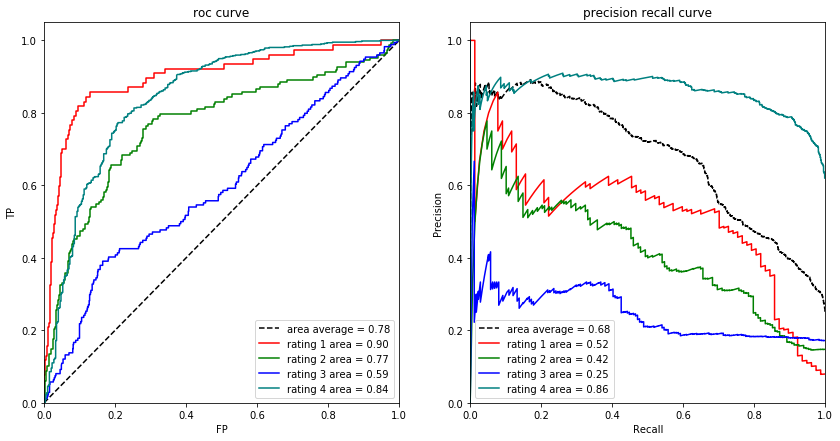

In [32]:
print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y, svm_pred_train), \
                                      metric.quadratic_weighted_kappa(y_dev, svm_pred_dev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y, svm_pred_train)**0.5, \
                                     mean_squared_error(y_dev, svm_pred_dev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svm_pred_dev!=y_dev)[0])), \
      confusion_matrix(y_dev, svm_pred_dev))
print('\nclassification_report :\n', classification_report(y_dev, svm_pred_dev))

now = time.localtime()
print("%02d:%02d:%02d"%(now.tm_hour, now.tm_min, now.tm_sec))
plot_multiclass_roc_prc(svm, X_scaled_dev, y_dev)

17:34:06


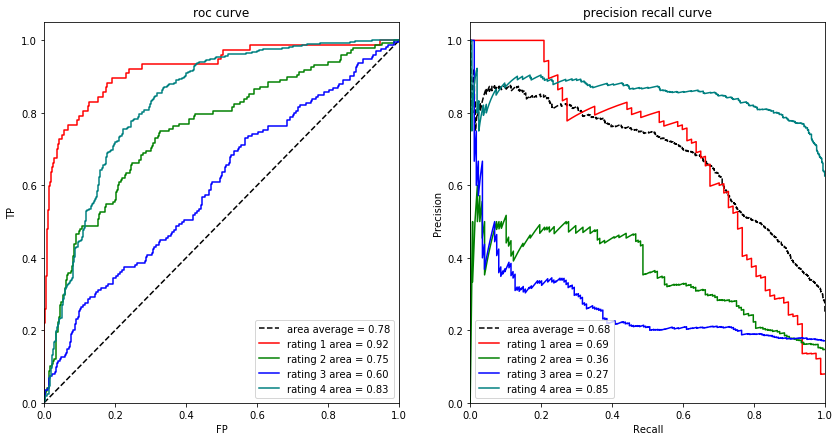

In [33]:
now = time.localtime()
print("%02d:%02d:%02d"%(now.tm_hour, now.tm_min, now.tm_sec))
plot_multiclass_roc_prc(svm, X_scaled_dev, y_dev)